# Smart Contract Languages by TVL

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Ramshreyas/Ethereum-Ecosystem-Studies/blob/main/Language_by_TVL.ipynb)

---   

### Imports & Setup

In [3]:
%pip install pandas requests matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.


In [4]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import re

In [5]:
# Hide warnings
import warnings
warnings.filterwarnings('ignore')

---

### Functions

DefiLlama




In [6]:
def fetch_defillama_protocols():
    """
    Fetches the list of protocols from DeFiLlama API.
    
    Returns:
        list: A list of protocol data in JSON format.
    """
    url = "https://api.llama.fi/protocols"
    try:
        response = requests.get(url)
        response.raise_for_status()
        protocols = response.json()
        return protocols
    except requests.exceptions.HTTPError as errh:
        print(f"HTTP Error: {errh}")
    except requests.exceptions.RequestException as err:
        print(f"Error: {err}")
    return []

def filter_ethereum_protocols(protocols):
    """
    Filters protocols to include only those operating on Ethereum Layer 1.
    
    Args:
        protocols (list): The list of all protocols fetched from DeFiLlama.
    
    Returns:
        pd.DataFrame: A DataFrame containing Ethereum protocols with relevant data.
    """
    data = []
    for protocol in protocols:
        if 'Ethereum' in protocol.get('chains', []):
            data.append({
                'name': protocol.get('name', ''),
                'symbol': protocol.get('symbol', ''),
                'category': protocol.get('category', ''),
                'tvl': protocol.get('tvl', 0),
                'chainTvls': protocol.get('chainTvls', {}).get('Ethereum', 0),
                'address': protocol.get('address', ''),
                'url': protocol.get('url', ''),
                'slug': protocol.get('slug', '')
            })
    df = pd.DataFrame(data)
    return df

def clean_protocols_data(df):
    """
    Cleans and preprocesses the protocols DataFrame.
    
    Args:
        df (pd.DataFrame): The DataFrame containing raw protocol data.
    
    Returns:
        pd.DataFrame: The cleaned and processed DataFrame.
    """
    # Convert TVL to numeric and fill missing values
    df['tvl'] = pd.to_numeric(df['tvl'], errors='coerce').fillna(0)
    df['chainTvls'] = pd.to_numeric(df['chainTvls'], errors='coerce').fillna(0)
    
    # Handle missing categories
    df['category'] = df['category'].fillna('Unknown')
    
    # Ensure addresses are in a consistent format
    df['address'] = df['address'].apply(lambda x: x if isinstance(x, str) else '')
    
    return df


Etherscan

In [7]:
def get_contract_source_code(address, api_key):
    """
    Fetches the contract source code and metadata from Etherscan API.
    
    Args:
        address (str): The contract address.
        api_key (str): Your Etherscan API key.
    
    Returns:
        dict: A dictionary containing the contract source code and metadata.
    """
    url = 'https://api.etherscan.io/api'
    params = {
        'module': 'contract',
        'action': 'getsourcecode',
        'address': address,
        'apikey': api_key
    }
    try:
        response = requests.get(url, params=params)
        response.raise_for_status()
        result = response.json()
        if result['status'] == '1':
            return result['result'][0]  # Return the first (and usually only) result
        else:
            print(f"Error fetching contract at {address}: {result['message']}")
            return None
    except requests.exceptions.HTTPError as errh:
        print(f"HTTP Error: {errh}")
    except requests.exceptions.RequestException as err:
        print(f"Error: {err}")
    return None

def extract_language(contract_info):
    """
    Determines the programming language used in the smart contract.
    
    Args:
        contract_info (dict): The contract information dictionary from Etherscan.
    
    Returns:
        str: The programming language ('Solidity', 'Vyper', 'Yul', 'Fe', 'Others', or 'Unknown').
    """
    compiler_version = contract_info.get('CompilerVersion', '')
    source_code = contract_info.get('SourceCode', '')
    
    # Check for Solidity
    if re.match(r'v\d+\.\d+\.\d+\+commit\.[\da-fA-F]{8}', compiler_version):
        return 'Solidity'
    # Check for Vyper
    elif 'vyper' in compiler_version.lower():
        return 'Vyper'
    # Check for Yul
    elif 'yul' in compiler_version.lower():
        return 'Yul'
    # Check for Fe
    elif 'fe' in compiler_version.lower():
        return 'Fe'
    else:
        # Try to infer from the source code
        source_code_lower = source_code.lower()
        if 'pragma solidity' in source_code_lower:
            return 'Solidity'
        elif 'pragma vyper' in source_code_lower:
            return 'Vyper'
        elif 'object "yul"' in source_code_lower:
            return 'Yul'
        elif 'pragma fe' in source_code_lower:
            return 'Fe'
        else:
            return 'Unknown'

def rate_limit_request(counter, max_requests=5, interval=1):
    """
    Implements a simple rate limiter to avoid exceeding API rate limits.
    
    Args:
        counter (int): The current request count.
        max_requests (int): Maximum number of requests allowed in the interval.
        interval (int): Time interval in seconds.
    """
    if counter % max_requests == 0 and counter != 0:
        print("Rate limit reached. Sleeping for a moment...")
        time.sleep(interval)

def is_contract_verified(contract_info):
    """
    Checks if the contract is verified on Etherscan.
    
    Args:
        contract_info (dict): The contract information dictionary from Etherscan.
    
    Returns:
        bool: True if the contract is verified, False otherwise.
    """
    return contract_info.get('ABI', '') != 'Contract source code not verified'


Visualization

In [ ]:
def filter_contracts_by_address_condition(df, condition_func):
    """
    Filters the contracts based on a condition applied to the 'address' column.

    Args:
        df (pd.DataFrame): The DataFrame containing contract data.
        condition_func (function): A function that takes an address and returns True if the row should be kept.

    Returns:
        pd.DataFrame: The filtered DataFrame.
    """
    filtered_df = df[df['address'].apply(condition_func)]
    return filtered_df

def plot_tvl_by_language(df):
    """
    Plots the distribution of TVL by smart contract language.

    Args:
        df (pd.DataFrame): The DataFrame containing contract data with 'Language' and 'tvl' columns.
    """
    # Aggregate TVL by Language
    language_tvl = df.groupby('Language')['tvl'].sum().reset_index()
    language_tvl = language_tvl.sort_values(by='tvl', ascending=False)

    # Create bar chart
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Language', y='tvl', data=language_tvl, palette='viridis')

    plt.title('TVL by Smart Contract Language')
    plt.xlabel('Smart Contract Language')
    plt.ylabel('Total Value Locked (USD)')
    plt.xticks(rotation=45)
    # Show y-axis in billions
    plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.FuncFormatter(lambda x, _: f'{x / 1e9:.0f}B'))
    plt.tight_layout()
    plt.show()

---

### Fetch DefiLlama data

In [9]:
# Fetch all protocols from DeFiLlama
protocols = fetch_defillama_protocols()

# Filter for Ethereum Layer 1 protocols
df_protocols = filter_ethereum_protocols(protocols)

# Clean and preprocess the data
df_protocols = clean_protocols_data(df_protocols)

# Display the first few rows of the DataFrame
df_protocols.head()

,name,symbol,category,tvl,chainTvls,address,url,slug
0,Binance CEX,-,CEX,1.496293e+11,4.475832e+10,,https://www.binance.com,binance-cex
1,Lido,LDO,Liquid Staking,3.393641e+10,3.391660e+10,0x5a98fcbea516cf06857215779fd812ca3bef1b32,https://lido.fi/,lido
2,Bitfinex,-,CEX,2.617642e+10,9.250310e+09,,https://www.bitfinex.com,bitfinex
3,OKX,-,CEX,2.565629e+10,1.074466e+10,,https://www.okx.com,okx
4,Robinhood,-,CEX,1.984038e+10,6.152562e+09,,https://robinhood.com,robinhood


---

### Replace with your Etherscan API key

In [ ]:
# Replace with your actual Etherscan API key
ETHERSCAN_API_KEY = ''

---

### Fetch Etherscan data

In [21]:
# Filter protocols with available contract addresses
df_contracts = df_protocols[df_protocols['address'].str.len() > 0].copy()
df_contracts.reset_index(drop=True, inplace=True)

# Initialize lists to store the results
languages = []
verified_status = []
errors = []

# Counter for rate limiting
request_counter = 0

# Iterate over the contract addresses
for idx, row in df_contracts.iterrows():
    address = row['address']
    # Etherscan API expects addresses in checksum format; ensure address is properly formatted
    address = address.strip()

    # Remove leading chain name like 'arbitrum:' if present
    address = address.split(':')[-1]
    
    # Fetch contract info from Etherscan
    contract_info = get_contract_source_code(address, ETHERSCAN_API_KEY)
    
    # Increment the request counter and apply rate limiting
    request_counter += 1
    rate_limit_request(request_counter, max_requests=5, interval=1)  # Adjust based on Etherscan's rate limits
    
    if contract_info:
        # Check if the contract is verified
        if is_contract_verified(contract_info):
            language = extract_language(contract_info)
            languages.append(language)
            verified_status.append('Verified')
            errors.append('')
        else:
            languages.append('Unknown')
            verified_status.append('Not Verified')
            errors.append('')
    else:
        languages.append('Unknown')
        verified_status.append('Error')
        errors.append(f"Failed to fetch data for address {address}")
        
# Add the results to the DataFrame
df_contracts['Language'] = languages
df_contracts['Verified'] = verified_status
df_contracts['Error'] = errors

# Display the updated DataFrame
df_contracts.head()


Rate limit reached. Sleeping for a moment...
Error fetching contract at 85VBFQZC9TZkfaptBWjvUw7YbZjy52A6mjtPGjstQAmQ: NOTOK
Rate limit reached. Sleeping for a moment...
Rate limit reached. Sleeping for a moment...
Rate limit reached. Sleeping for a moment...
Rate limit reached. Sleeping for a moment...
Rate limit reached. Sleeping for a moment...
Rate limit reached. Sleeping for a moment...
Rate limit reached. Sleeping for a moment...
Rate limit reached. Sleeping for a moment...
Rate limit reached. Sleeping for a moment...
Rate limit reached. Sleeping for a moment...
Rate limit reached. Sleeping for a moment...
Rate limit reached. Sleeping for a moment...
Rate limit reached. Sleeping for a moment...
Rate limit reached. Sleeping for a moment...
Rate limit reached. Sleeping for a moment...
Error fetching contract at -: NOTOK
Rate limit reached. Sleeping for a moment...
Error fetching contract at TThzxNRLrW2Brp9DcTQU8i4Wd9udCWEdZ3: NOTOK
Rate limit reached. Sleeping for a moment...
Rate l

,name,symbol,category,tvl,chainTvls,address,url,slug,Language,Verified,Error
0,Lido,LDO,Liquid Staking,3.393641e+10,3.391660e+10,0x5a98fcbea516cf06857215779fd812ca3bef1b32,https://lido.fi/,lido,Solidity,Verified,
1,AAVE V3,AAVE,Lending,1.806891e+10,1.553981e+10,0x7fc66500c84a76ad7e9c93437bfc5ac33e2ddae9,https://aave.com,aave-v3,Solidity,Verified,
2,Arbitrum Bridge,ARB,Chain,1.003019e+10,1.003019e+10,arbitrum:0x912ce59144191c1204e64559fe8253a0e49...,https://bridge.arbitrum.io,arbitrum-bridge,Solidity,Verified,
3,ether.fi Stake,ETHFI,Liquid Restaking,7.766168e+09,7.766168e+09,0xfe0c30065b384f05761f15d0cc899d4f9f9cc0eb,https://app.ether.fi/eeth,ether.fi-stake,Solidity,Verified,
4,MakerDAO,MKR,CDP,5.397353e+09,5.397353e+09,0x9f8f72aa9304c8b593d555f12ef6589cc3a579a2,https://makerdao.com/,makerdao,Solidity,Verified,


---

### Coverage

Proportion of TVL covered

In [22]:
# Magic store the variables
# %store df_protocols
# %store df_contracts

In [23]:
# total TVL with detected languages / Total TVL
total_tvl = df_contracts['tvl'].sum()
total_tvl_detected = df_contracts[df_contracts['Language'] != 'Unknown']['tvl'].sum()
float(total_tvl_detected / total_tvl)

0.8958820355586942

List of detected languages on L1

In [24]:
# List unique languages detected
df_contracts['Language'].unique()

array(['Solidity', 'Unknown', 'Vyper'], dtype=object)

Undetected language contracts

In [25]:
# Display contracts with unknown languages or errors
df_unknown = df_contracts[(df_contracts['Language'] == 'Unknown') | (df_contracts['Verified'] != 'Verified')]
df_unknown[['name', 'address', 'Language', 'Verified', 'Error']].head()

,name,address,Language,Verified,Error
5,Optimism Bridge,optimism:0x42000000000000000000000000000000000...,Unknown,Not Verified,
6,Portal,solana:85VBFQZC9TZkfaptBWjvUw7YbZjy52A6mjtPGjs...,Unknown,Error,Failed to fetch data for address 85VBFQZC9TZkf...
14,Venus Core Pool,bsc:0xcf6bb5389c92bdda8a3747ddb454cb7a64626c63,Unknown,Not Verified,
18,PancakeSwap AMM,bsc:0x0E09FaBB73Bd3Ade0a17ECC321fD13a19e81cE82,Unknown,Not Verified,
36,PancakeSwap AMM V3,bsc:0x0E09FaBB73Bd3Ade0a17ECC321fD13a19e81cE82,Unknown,Not Verified,


---

### Distribution of Langauges by TVL

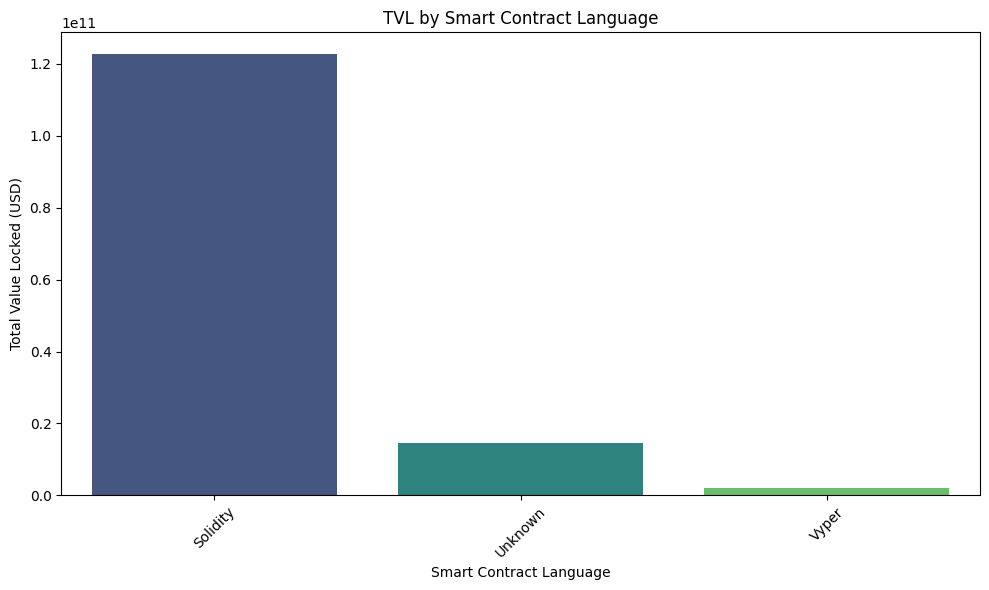

In [26]:
# Plot TVL by Language using the unfiltered DataFrame
plot_tvl_by_language(df_contracts)